This Kernel is an extension for one of my blogs on Visualization. 

Do check it out: [3 Awesome Visualization Techniques for every dataset](https://mlwhiz.com/blog/2019/04/19/awesome_seaborn_visuals/)

![](https://mlwhiz.com/images/visualizations/kelly_Sikemma.jpeg)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import seaborn as sns
# Any results you write to the current directory are saved as output.

import matplotlib.pyplot as plt
%matplotlib inline

# We dont Probably need the Gridlines. Do we? If yes comment this line
sns.set(style="ticks")

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = sns.color_palette(flatui)


['train.csv', 'test.csv', 'googleplaystore.csv', 'googleplaystore_user_reviews.csv', 'data.csv']


In [2]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
import scipy.stats as ss
from collections import Counter
import math 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
#     else:
#         raise ValueError("Unknown data conversion: {}".format(to))
#     if converted is None:
#         raise TypeError('cannot handle data conversion of type: {} to {}'.format(type(data),to))
#     else:
    return converted
    
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
    continuous features using:
     - Pearson's R for continuous-continuous cases
     - Correlation Ratio for categorical-continuous cases
     - Cramer's V or Theil's U for categorical-categorical cases
    :param dataset: NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed
    :param nominal_columns: string / list / NumPy ndarray
        Names of columns of the data-set which hold categorical values. Can also be the string 'all' to state that all
        columns are categorical, or None (default) to state none are categorical
    :param mark_columns: Boolean (default: False)
        if True, output's columns' names will have a suffix of '(nom)' or '(con)' based on there type (eda_tools or
        continuous), as provided by nominal_columns
    :param theil_u: Boolean (default: False)
        In the case of categorical-categorical feaures, use Theil's U instead of Cramer's V
    :param plot: Boolean (default: True)
        If True, plot a heat-map of the correlation matrix
    :param return_results: Boolean (default: False)
        If True, the function will return a Pandas DataFrame of the computed associations
    :param kwargs:
        Arguments to be passed to used function and methods
    :return: Pandas DataFrame
        A DataFrame of the correlation/strength-of-association between all features
    """

    dataset = convert(dataset, 'dataframe')
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        plt.figure(figsize=(20,20))#kwargs.get('figsize',None))
        sns.heatmap(corr, annot=kwargs.get('annot',True), fmt=kwargs.get('fmt','.2f'), cmap='coolwarm')
        plt.show()
    if return_results:
        return corr

## Reading the Data and Preprocessing

In [3]:
player_df = pd.read_csv("../input/data.csv")

In [4]:
def wage_split(x):
    try:
        return int(x.split("K")[0][1:])
    except:
        return 0
player_df['Wage'] = player_df['Wage'].apply(lambda x : wage_split(x))

def value_split(x):
    try:
        if 'M' in x:
            return float(x.split("M")[0][1:])
        elif 'K' in x:
            return float(x.split("K")[0][1:])/1000
    except:
        return 0
player_df['Value'] = player_df['Value'].apply(lambda x : value_split(x))

In [5]:
numcols = [
 'Overall',
 'Potential',
'Crossing','Finishing',  'ShortPassing',  'Dribbling','LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility',  'Stamina',
 'Value','Wage']
catcols = ['Name','Club','Nationality','Preferred Foot','Position','Body Type']


In [6]:
player_df = player_df[numcols+ catcols]

# Simple Correlation Plot

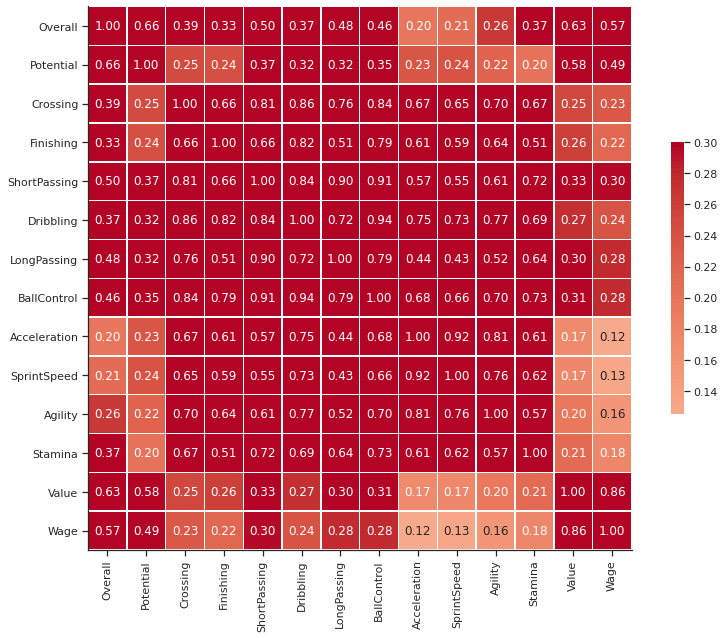

In [7]:
corr = player_df.corr()

g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')

sns.despine()
g.figure.set_size_inches(14,10)
    
plt.show()

# Our New and Improved Correlation Plot

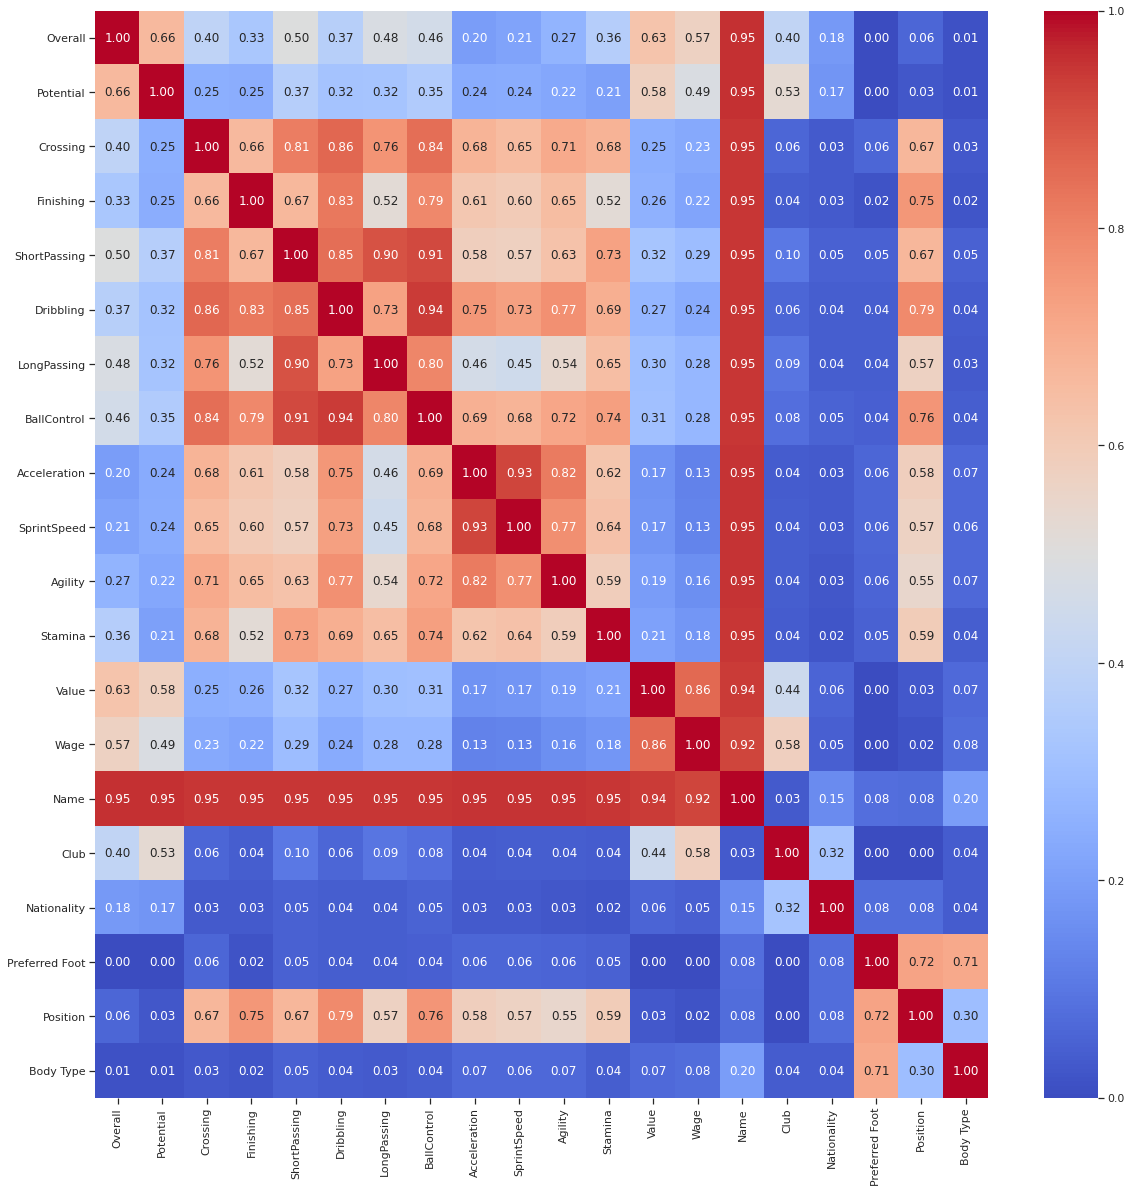

In [8]:
player_df = player_df.fillna(0)
results = associations(player_df,nominal_columns=catcols,return_results=True)

Subset data and create Stacked Plot between club and nationality

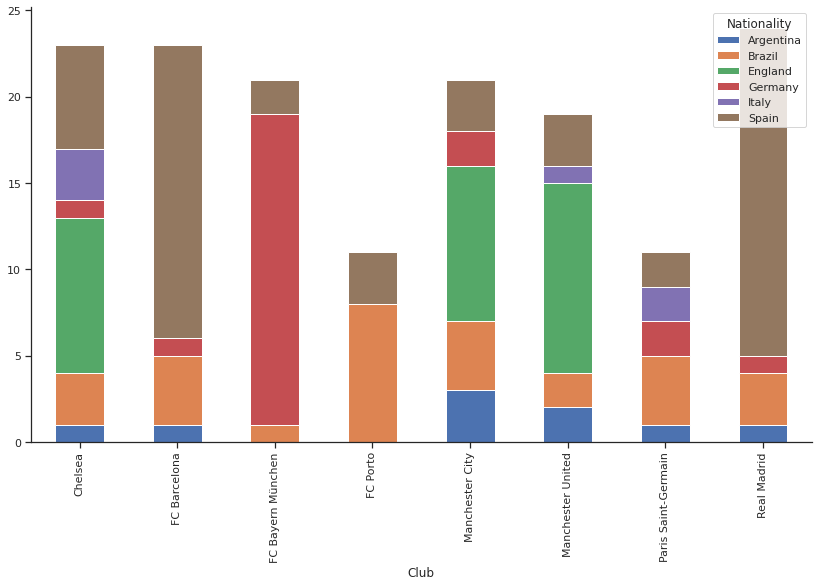

In [9]:
sns.set(style="ticks")

filtered_player_df = player_df[(player_df['Club'].isin(['FC Barcelona', 'Paris Saint-Germain',
       'Manchester United', 'Manchester City', 'Chelsea', 'Real Madrid','FC Porto','FC Bayern München'])) & 
                      (player_df['Nationality'].isin(['England', 'Brazil', 'Argentina',
       'Brazil', 'Italy','Spain','Germany'])) 
                     ]

df_plot = filtered_player_df.groupby(['Club', 'Nationality']).size().reset_index().pivot(columns='Club', index='Nationality', values=0).reset_index()

g = df_plot.set_index('Nationality').T.plot(kind='bar', stacked=True, 
            color=sns.color_palette())
sns.despine()
g.figure.set_size_inches(14,8)
    
plt.show()

## Pairplots

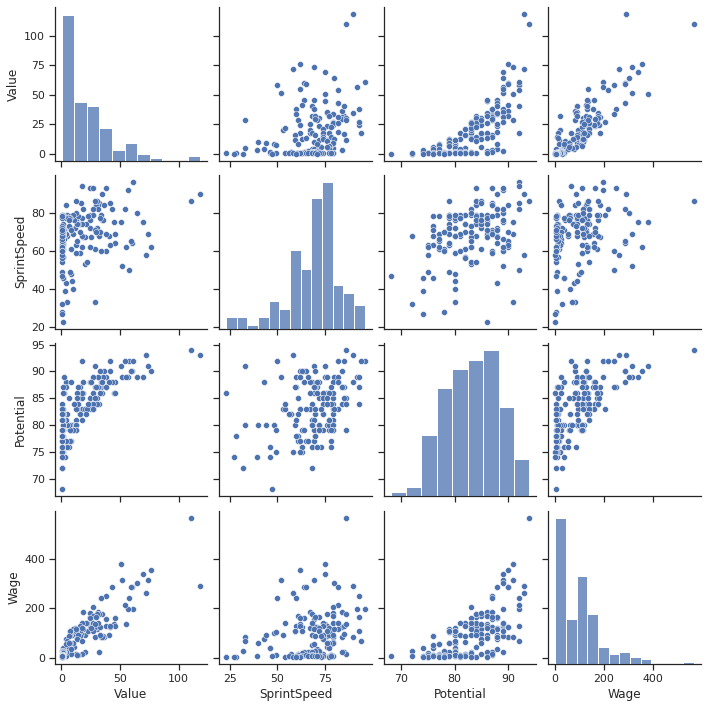

In [10]:
g = sns.pairplot(filtered_player_df[['Value','SprintSpeed','Potential','Wage']])

In [ ]:
g = sns.pairplot(filtered_player_df[['Value','SprintSpeed','Potential','Wage','Club']],hue = 'Club')

# Swarmplots

In [ ]:
# Plot beeswarm with x as O3

g = sns.swarmplot(y = "Club",
              x = 'Wage', 
              data = filtered_player_df,
              # Decrease the size of the points to avoid crowding 
              size = 7)

# remove the top and right line in graph
sns.despine()
g.figure.set_size_inches(14,10)
# Give a descriptive title

plt.show()

In [ ]:

g = sns.boxplot(y = "Club",
              x = 'Wage', 
              data = filtered_player_df, whis=np.inf)

g = sns.swarmplot(y = "Club",
              x = 'Wage', 
              data = filtered_player_df,
              # Decrease the size of the points to avoid crowding 
              size = 7,color = 'black')

# remove the top and right line in graph
sns.despine()


g.figure.set_size_inches(12,8)

plt.show()

In [ ]:
max_wage = filtered_player_df.Wage.max()
max_wage_player = filtered_player_df[(player_df['Wage'] == max_wage)]['Name'].values[0]

In [ ]:
max_wage = filtered_player_df.Wage.max()
max_wage_player = filtered_player_df[(player_df['Wage'] == max_wage)]['Name'].values[0]
g = sns.boxplot(y = "Club",
              x = 'Wage', 
              data = filtered_player_df, whis=np.inf)
g = sns.swarmplot(y = "Club",
              x = 'Wage', 
              data = filtered_player_df,
              # Decrease the size of the points to avoid crowding 
              size = 7,color='black')
# remove the top and right line in graph
sns.despine()

# Annotate. xy for coordinate. max_wage is x and 0 is y. In this plot y ranges from 0 to 7 for each level
# xytext for coordinates of where I want to put my text
plt.annotate(s = max_wage_player,
             xy = (max_wage,0),
             xytext = (500,1), 
             # Shrink the arrow to avoid occlusion
             arrowprops = {'facecolor':'gray', 'width': 3, 'shrink': 0.03},
             backgroundcolor = 'white')
g.figure.set_size_inches(12,8)

plt.show()